In [1]:
import os
import torch
import sys
import torch.nn.functional as F
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


sys.path.append('../..')
from train_cvae import train_cvae
from utils.utils import un_normalize, normalize, samples_per_class, normalize_min_max

In [2]:
imb_path = '/mnt/dtafler/test/timm/vit_base_patch14_dinov2.lvd142m/cifar100_0.01'
bal_path = '/mnt/dtafler/test/timm/vit_base_patch14_dinov2.lvd142m/cifar100_bal'

save_path = './diversity_results'

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
if os.path.exists(os.path.join(save_path, 'small', 'cvae')):
    small_cvae = torch.load(os.path.join(save_path, 'small', 'cvae', 'cvae.pth'))
else:
    small_cvae, small_hist, small_normed_train_ds, small_normed_test_ds = train_cvae(data_path=imb_path,
                                            save_path=os.path.join(save_path, 'small', 'cvae'),
                                            num_classes=100,
                                            input_dim=768,
                                            epochs=500,
                                            hidden_dim=512,
                                            latent_dim=100,
                                            beta=0.01,
                                            small=True)

if os.path.exists(os.path.join(save_path, 'large', 'cvae')):
    cvae = torch.load(os.path.join(save_path, 'large', 'cvae', 'cvae.pth'))
else:
    cvae, hist, normed_train_ds, normed_test_ds = train_cvae(data_path=imb_path,
                                            save_path=os.path.join(save_path, 'large', 'cvae'),
                                            num_classes=100,
                                            input_dim=768,
                                            epochs=500,
                                            hidden_dim=512,
                                            latent_dim=100,
                                            beta=0.01)



In [4]:
print(sum([p.numel() for p in cvae.parameters()]))
print(sum([p.numel() for p in small_cvae.parameters()]))

3120584
1044424


In [5]:
# coverage
bal_feats = torch.load(os.path.join(bal_path, 'train', 'embeds_cls.pt'))
bal_labels = torch.load(os.path.join(bal_path, 'train', 'labels.pt'))

imb_feats = torch.load(os.path.join(imb_path, 'train', 'embeds_cls.pt'))
imb_lables = torch.load(os.path.join(imb_path, 'train', 'labels.pt'))

def knn_coverage(ground, generated, k=1):
    distances = torch.cdist(ground, generated)
    # Get the indices of the k nearest neighbors for each generated point
    _, nearest_neighbors = torch.topk(distances, k, largest=False, dim=0)
    unique_nearest_neighbors = torch.unique(nearest_neighbors)
    return unique_nearest_neighbors.shape[0] / ground.shape[0]

def coverage(model, k, recon=False, var=1, baseline=False):
    if baseline:
        coverage = []
        for i in range(100):
            orig_samples = bal_feats[bal_labels == i]
            samples = imb_feats[imb_lables == i]
            coverage.append(knn_coverage(orig_samples, samples, k=k))
        return coverage
    
    model.eval()
    coverage = []
    for i in range(100):
        if recon:
            idx = bal_labels == i
            orig_samples = bal_feats[idx]
            x = normalize_min_max(orig_samples, model.norm_min, model.norm_max, device=device)
            y = F.one_hot(torch.tensor([i]), num_classes=100).to(device)
            y = y.repeat(x.shape[0], 1)
            with torch.no_grad():
                samples = model(x, y)
            samples = un_normalize(samples, model.norm_min, model.norm_max)
            
        else:
            # generate samples
            latents = var * torch.randn((500, model.latent_dim)).to(device)
            y_oh = F.one_hot(torch.tensor([i]), num_classes=100).to(device)
            y_ohs = y_oh.repeat(500, 1)
            with torch.no_grad():
                samples = model.decoder(latents, y_ohs)
            samples = un_normalize(samples, model.norm_min, model.norm_max)
            
        # coverage of original full samples
        orig_samples = bal_feats[bal_labels == i]
        coverage.append(knn_coverage(orig_samples, samples, k=k))  # Adjust k as needed
    return coverage



In [6]:

# # Define plot styles and labels
# styles = [':', '-.', '-', '--']
# labels = ['CVAE train set', 'Reconstructed', 'Generated (var = 1)', 'Generated (var = 2)']

# cmap = plt.get_cmap('tab10')
# colors = [cmap(i) for i in range(4)]
# font_size = 14
# line_width = 1

# # Generate the plots
# fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

# # Plot for Small CVAE - Reconstructed
# axs[0, 0].plot(coverage(small_cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[0])
# axs[0, 0].plot(coverage(small_cvae, k=1, recon=True), label=labels[1], linestyle=styles[1], linewidth=line_width, color=colors[1])
# axs[0, 0].set_title('Small CVAE - Reconstructed', fontsize=font_size)
# axs[0, 0].set_xlabel('Class Index', fontsize=font_size)
# axs[0, 0].set_ylabel('Coverage', fontsize=font_size)
# axs[0, 0].grid(True)

# # Plot for Small CVAE - Generated (var = 1)
# axs[0, 1].plot(coverage(small_cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[0])
# axs[0, 1].plot(coverage(small_cvae, k=1), label=labels[2], linestyle=styles[2], linewidth=line_width, color=colors[2])
# axs[0, 1].set_title('Small CVAE - Generated (var = 1)', fontsize=font_size)
# axs[0, 1].set_xlabel('Class Index', fontsize=font_size)
# axs[0, 1].grid(True)

# # Plot for Small CVAE - Generated (var = 2)
# axs[0, 2].plot(coverage(small_cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[0])
# axs[0, 2].plot(coverage(small_cvae, k=1, var=2), label=labels[3], linestyle=styles[3], linewidth=line_width, color=colors[3])
# axs[0, 2].set_title('Small CVAE - Generated (var = 2)', fontsize=font_size)
# axs[0, 2].set_xlabel('Class Index', fontsize=font_size)
# axs[0, 2].grid(True)

# # Plot for Large CVAE - Reconstructed
# axs[1, 0].plot(coverage(cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[0])
# axs[1, 0].plot(coverage(cvae, k=1, recon=True), label=labels[1], linestyle=styles[1], linewidth=line_width, color=colors[1])
# axs[1, 0].set_title('Large CVAE - Reconstructed', fontsize=font_size)
# axs[1, 0].set_xlabel('Class Index', fontsize=font_size)
# axs[1, 0].set_ylabel('Coverage', fontsize=font_size)
# axs[1, 0].grid(True)

# # Plot for Large CVAE - Generated (var = 1)
# axs[1, 1].plot(coverage(cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[0])
# axs[1, 1].plot(coverage(cvae, k=1), label=labels[2], linestyle=styles[2], linewidth=line_width, color=colors[2])
# axs[1, 1].set_title('Large CVAE - Generated (var = 1)', fontsize=font_size)
# axs[1, 1].set_xlabel('Class Index', fontsize=font_size)
# axs[1, 1].grid(True)

# # Plot for Large CVAE - Generated (var = 2)
# axs[1, 2].plot(coverage(cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[0])
# axs[1, 2].plot(coverage(cvae, k=1, var=2), label=labels[3], linestyle=styles[3], linewidth=line_width, color=colors[3])
# axs[1, 2].set_title('Large CVAE - Generated (var = 2)', fontsize=font_size)
# axs[1, 2].set_xlabel('Class Index', fontsize=font_size)
# axs[1, 2].grid(True)

# # Create a common legend
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', fontsize=font_size, ncol=4)

# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()
# plt.savefig('coverage_split.png', dpi=300)

In [7]:
# # Generate the plots
# fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
# font_size = 14
# line_width = 1

# # Define plot styles and labels
# styles = [':', '-.', '-', '--']
# # labels = ['Generated (var = 1)', 'Generated (var = 2)', 'CVAE train set', 'Reconstructed']
# labels = ['CIFAR100-LT', 'Reconstructed', 'Generated (var = 1)', 'Generated (var = 2)']

# cmap = plt.get_cmap('tab10')
# colors = [cmap(i) for i in range(4)]

# # Plot for Small CVAE
# axs[0].plot(coverage(small_cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[2])
# axs[0].plot(coverage(small_cvae, k=1, recon=True), label=labels[1], linestyle=styles[1], linewidth=line_width, color=colors[3])
# axs[0].plot(coverage(small_cvae, k=1), label=labels[2], linestyle=styles[2], linewidth=line_width, color=colors[0])
# axs[0].plot(coverage(small_cvae, k=1, var=2), label=labels[3], linestyle=styles[3], linewidth=line_width, color=colors[1])
# axs[0].set_title('Small CVAE', fontsize=font_size)
# axs[0].set_xlabel('Class Index', fontsize=font_size)
# axs[0].set_ylabel('Coverage', fontsize=font_size)
# axs[0].grid(True)

# # Plot for Large CVAE
# axs[1].plot(coverage(cvae, k=1, baseline=True), label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[2])
# axs[1].plot(coverage(cvae, k=1, recon=True), label=labels[1], linestyle=styles[1], linewidth=line_width, color=colors[3])
# axs[1].plot(coverage(cvae, k=1), label=labels[2], linestyle=styles[2], linewidth=line_width, color=colors[0])
# axs[1].plot(coverage(cvae, k=1, var=2), label=labels[3], linestyle=styles[3], linewidth=line_width, color=colors[1])
# axs[1].set_title('Large CVAE', fontsize=font_size)
# axs[1].set_xlabel('Class Index', fontsize=font_size)
# axs[1].grid(True)

# # Create a common legend
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', fontsize=font_size, ncol=4)
# # fig.legend(handles, labels, loc='upper center', fontsize=font_size, ncol=4, prop={'weight': 'bold'})

# plt.tight_layout(rect=[0, 0, 1, 0.93])
# plt.savefig('coverage.png', dpi=300)
# plt.show()

In [8]:

# spc = samples_per_class(torch.load(os.path.join(imb_path, 'train', 'labels.pt')))

# fig, axs = plt.subplots(2, 3, figsize=(15, 10))
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Define a consistent color scheme
# font_size = 12

# for col, k in enumerate([1, 5, 10]):
#     for row, size in enumerate(['small', 'large']):
#         if size == 'small':
#             model = small_cvae
#         else:
#             model = cvae
            
#         axs[row, col].plot(coverage(model, k), label='Generated var = 1')
#         axs[row, col].plot(coverage(model, k, var=2), label='Generated var = 2')
#         # axs[row, col].plot(coverage(model, k, var=3), label='Generated var = 3')
#         # axs[row, col].plot(coverage(model, k, var=5), label='Generated var = 5')
#         # axs[row, col].plot(coverage(model, k, var=10), label='Generated var = 10')
#         axs[row, col].plot(coverage(model, k, var=20), label='Generated var = 20')
#         axs[row, col].plot(coverage(model, k, recon=True), label='Reconstructed')
#         # axs[row, col].plot(spc/spc.max(), label='Class Sizes', color=colors[2])
#         axs[row, col].plot(coverage(model, k, baseline=True), label='CVAE train set', color='black')
#         if row == 1:
#             axs[row, col].set_xlabel('Class Index', fontsize=font_size)
#         if col == 0:
#             axs[row, col].set_ylabel('Coverage', fontsize=font_size)
#         axs[row, col].set_title(f'k = {k}, {size} model', fontsize=font_size) 
#         axs[row, col].grid(True)  # Add grid lines

# # Adjust layout to make room for the suptitle and remove redundant labels
# # fig.suptitle('KNN Coverage per Class', fontsize=20) #  fontweight='bold'
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# # fig.tight_layout(rect=[0, 0, 1, 1])
# # fig.subplots_adjust(wspace=0.3, hspace=0.3)

# # Add a common legend
# handles, labels = axs[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=font_size)

# plt.show()

In [9]:
# def rebalance(model):
#     model.eval()
    
#     # how many samples to generate per class
#     imb_feats = torch.load(os.path.join(imb_path, 'train', 'embeds_cls.pt'))
#     imb_labels = torch.load(os.path.join(imb_path, 'train', 'labels.pt'))
    
#     spc = samples_per_class(imb_labels)
#     to_gen = spc.max() - spc

#     # generate samples
#     gen_feats = []
#     gen_labels = []
#     for i in range(100):
#         if to_gen[i].item() > 0:
#             # var = torch.linspace(2,10,100)[i]
#             latents = torch.randn((to_gen[i], model.latent_dim)).to(device)
#             y_oh = F.one_hot(torch.tensor(i), num_classes=100).to(device)
#             ys_oh = y_oh.repeat(to_gen[i], 1)
#             x_hat = model.decoder(latents, ys_oh)
#             gen_feats.append(x_hat)
#             gen_labels.append(torch.tensor(i).repeat(to_gen[i]))
            
#     gen_feats = torch.cat(gen_feats, dim=0)
#     gen_labels = torch.cat(gen_labels, dim=0)

#     # un-normalize
#     gen_feats = un_normalize(gen_feats, model.norm_min, model.norm_max)
    
#     # add to imbalanced data
#     rebalanced_feats = torch.cat((imb_feats.to('cpu'), gen_feats.to('cpu')), dim=0).detach()
#     rebalanced_labels = torch.cat((imb_labels.to('cpu'), gen_labels.to('cpu')), dim=0).detach()
    
#     return rebalanced_feats, rebalanced_labels

# def reconstruct(model):
#     model.eval()
    
#     bal_feats = torch.load(os.path.join(bal_path, 'train', 'embeds_cls.pt'))
#     bal_labels = torch.load(os.path.join(bal_path, 'train', 'labels.pt'))
    
#     recon_feats = []
#     recon_labels = []
    
#     for i in range(100):
#         idx = bal_labels == i
#         orig_samples = bal_feats[idx]
#         x = normalize_min_max(orig_samples, model.norm_min, model.norm_max, device=device)
#         y = F.one_hot(torch.tensor([i]), num_classes=100).to(device)
#         y = y.repeat(x.shape[0], 1)
#         with torch.no_grad():
#             samples = model(x, y)
#         samples = un_normalize(samples, model.norm_min, model.norm_max)
#         recon_feats.append(samples)
#         recon_labels.append(torch.tensor(i).repeat(samples.shape[0]))
        
#     recon_feats = torch.cat(recon_feats, dim=0)
#     recon_labels = torch.cat(recon_labels, dim=0)
    
#     return recon_feats, recon_labels
    
    
# # load imbalanced data
# imb_feats = torch.load(os.path.join(imb_path, 'train', 'embeds_cls.pt')).numpy()
# imb_labels = torch.load(os.path.join(imb_path, 'train', 'labels.pt')).numpy()
# print(imb_feats.shape, imb_labels.shape)

# # load balanced data
# bal_feats = torch.load(os.path.join(bal_path, 'train', 'embeds_cls.pt')).numpy()
# bal_labels = torch.load(os.path.join(bal_path, 'train', 'labels.pt')).numpy()
# print(bal_feats.shape, bal_labels.shape)


# # rebalanced
# rebalanced_feats, rebalanced_labels = rebalance(cvae)
# rebalanced_feats, rebalanced_labels = rebalanced_feats.numpy(), rebalanced_labels.numpy()
# print(rebalanced_feats.shape, rebalanced_labels.shape)

# small_rebalanced_feats, small_rebalanced_labels = rebalance(small_cvae)
# small_rebalanced_feats, small_rebalanced_labels = small_rebalanced_feats.numpy(), small_rebalanced_labels.numpy()
# print(small_rebalanced_feats.shape, small_rebalanced_labels.shape)


# # reconstructed
# recon_feats, recon_labels = reconstruct(cvae)
# recon_feats, recon_labels = recon_feats.numpy(), recon_labels.numpy()
# print(recon_feats.shape, recon_labels.shape)

# small_recon_feats, small_recon_labels = reconstruct(small_cvae)
# small_recon_feats, small_recon_labels = small_recon_feats.numpy(), small_recon_labels.numpy()
# print(small_recon_feats.shape, small_recon_labels.shape)

In [10]:
def get_class(samples, labels, cls):
    idx = labels == cls
    return samples[idx]

In [11]:
# # minimum bounding sphere
# min_ball_save_path = os.path.join(save_path, 'min_ball')

# def min_ball(points: np.ndarray, include_percentile=100):
#     assert points.ndim == 2, "points must be a 2D numpy array"
    
#     # Function to calculate the distance from a point to all points in the set
#     def distance_to_farthest_point(center, points):
#         distances = np.linalg.norm(points - center, axis=1)
#         return np.max(distances)
    
#     # Initial guess for the center: mean of the points
#     initial_center = np.mean(points, axis=0)
#     # remove potential outliers
#     dists = np.linalg.norm(points - initial_center, axis=1)
#     points = points[dists <= np.percentile(dists, include_percentile)]

#     # Optimization to find the center of the minimum bounding sphere
#     result = minimize(lambda x: distance_to_farthest_point(x, points), initial_center, method='L-BFGS-B')
#     center = result.x

#     # Calculate the radius of the minimum bounding sphere
#     radius = distance_to_farthest_point(center, points)

#     return center, radius


# # min_rads_imb = []
# # min_rads_bal = []
# # min_rads_reb = []
# # min_rads_small_reb = []
# recon_rads = []
# recon_rads_small = []

# for i in tqdm(range(100)):
#     # min_rads_imb.append(min_ball(get_class(imb_feats, imb_labels, i), include_percentile=100)[1])
#     # min_rads_bal.append(min_ball(get_class(bal_feats, bal_labels, i), include_percentile=100)[1])
#     # min_rads_reb.append(min_ball(get_class(rebalanced_feats, rebalanced_labels, i), include_percentile=100)[1])
#     # min_rads_small_reb.append(min_ball(get_class(small_rebalanced_feats, small_rebalanced_labels, i), include_percentile=100)[1])
#     recon_rads.append(min_ball(get_class(recon_feats, recon_labels, i), include_percentile=100)[1])
#     recon_rads_small.append(min_ball(get_class(small_recon_feats, small_recon_labels, i), include_percentile=100)[1])
    
# def save_as_tensor(l: list, save_path: str):
#     assert not os.path.exists(save_path), f'{save_path} already exists'
#     if not os.path.exists(os.path.dirname(save_path)):
#         os.makedirs(os.path.dirname(save_path))
#     l = torch.tensor(l)
#     torch.save(l, save_path)

# # save_as_tensor(min_rads_imb, os.path.join(min_ball_save_path, 'min_rads_imb.pt'))
# # save_as_tensor(min_rads_bal, os.path.join(min_ball_save_path, 'min_rads_bal.pt'))
# # save_as_tensor(min_rads_reb, os.path.join(min_ball_save_path, 'min_rads_reb.pt'))
# # save_as_tensor(min_rads_small_reb, os.path.join(min_ball_save_path, 'min_rads_small_reb.pt'))
# save_as_tensor(recon_rads, os.path.join(min_ball_save_path, 'recon_rads.pt'))
# save_as_tensor(recon_rads_small, os.path.join(min_ball_save_path, 'recon_rads_small.pt'))

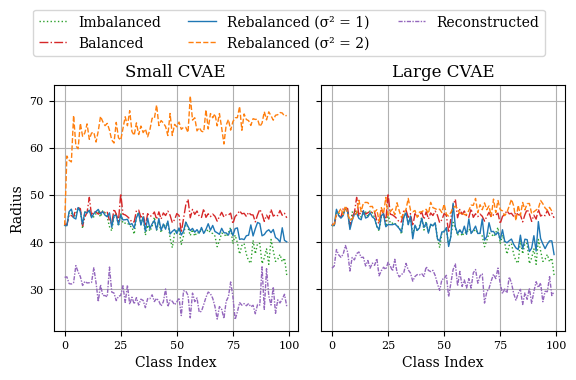

In [12]:
rads_imb = torch.load(os.path.join(save_path, 'min_ball', 'min_rads_imb.pt')).numpy()
rads_bal = torch.load(os.path.join(save_path, 'min_ball', 'min_rads_bal.pt')).numpy()
rads_reb = torch.load(os.path.join(save_path, 'min_ball', 'min_rads_reb.pt')).numpy()
rads_small_reb = torch.load(os.path.join(save_path, 'min_ball', 'min_rads_small_reb.pt')).numpy()

# rads_imb_var2 = torch.load(os.path.join(save_path, 'min_ball', 'var2', 'min_rads_imb.pt')).numpy()
# rads_bal_var2 = torch.load(os.path.join(save_path, 'min_ball', 'var2', 'min_rads_bal.pt')).numpy()
rads_reb_var2 = torch.load(os.path.join(save_path, 'min_ball', 'var2', 'min_rads_reb.pt')).numpy()
rads_small_reb_var2 = torch.load(os.path.join(save_path, 'min_ball', 'var2', 'min_rads_small_reb.pt')).numpy()

# rads_imb_var3 = torch.load(os.path.join(save_path, 'min_ball', 'var3', 'min_rads_imb.pt')).numpy()
# rads_bal_var3 = torch.load(os.path.join(save_path, 'min_ball', 'var3', 'min_rads_bal.pt')).numpy()
# rads_reb_var3 = torch.load(os.path.join(save_path, 'min_ball', 'var3', 'min_rads_reb.pt')).numpy()
# rads_small_reb_var3 = torch.load(os.path.join(save_path, 'min_ball', 'var3', 'min_rads_small_reb.pt')).numpy()

rads_recon = torch.load(os.path.join(save_path, 'min_ball', 'recon_rads.pt')).numpy()
rads_small_recon = torch.load(os.path.join(save_path, 'min_ball', 'recon_rads_small.pt')).numpy()


# Define the styles and colors
# styles = [':', '-.', '-', '--']
styles = [':', '-.', '-', '--', (0, (3, 1, 1, 1))]
labels = ['Imbalanced', 'Balanced', 'Rebalanced (\u03C3² = 1)', 'Rebalanced (\u03C3² = 2)', 'Reconstructed']
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(5)]
font_size = 14
line_width = 1


# Configure Matplotlib to use DejaVu Serif
plt.rc('font', family='serif')
plt.rc('font', serif='DejaVu Serif')
plt.rc('text', usetex=False)  # Disable LaTeX

# Define the figure width in points (1 * 15 cm in points)
fig_width_pt = 425.196
fig_width_in = fig_width_pt / 72.27
fig_height_in = fig_width_in * 0.65

fig, axs = plt.subplots(1, 2, figsize=(fig_width_in, fig_height_in), sharey=True)

# Generate the plots
# fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot for Small Model
axs[0].plot(rads_imb, label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[2])
axs[0].plot(rads_bal, label=labels[1], linestyle=styles[1], linewidth=line_width, color=colors[3])
axs[0].plot(rads_small_reb, label=labels[2], linestyle=styles[2], linewidth=line_width, color=colors[0])
axs[0].plot(rads_small_reb_var2, label=labels[3], linestyle=styles[3], linewidth=line_width, color=colors[1])
# axs[0].plot(rads_small_reb_var3, label=labels[4], linestyle=styles[4], linewidth=line_width, color=colors[4])
axs[0].plot(rads_small_recon, label=labels[4], linestyle=styles[4], linewidth=line_width, color=colors[4])

axs[0].set_xticks(range(0,101,25))
axs[0].set_xticklabels(range(0,101,25))
axs[0].tick_params(axis='both', which='major', labelsize=8)

axs[0].set_title('Small CVAE', fontsize=12)
axs[0].set_xlabel('Class Index', fontsize=10)
axs[0].set_ylabel('Radius', fontsize=10)
axs[0].grid(True)


# Plot for Large Model
axs[1].plot(rads_imb, label=labels[0], linestyle=styles[0], linewidth=line_width, color=colors[2])
axs[1].plot(rads_bal, label=labels[1], linestyle=styles[1], linewidth=line_width, color=colors[3])
axs[1].plot(rads_reb, label=labels[2], linestyle=styles[2], linewidth=line_width, color=colors[0])
axs[1].plot(rads_reb_var2, label=labels[3], linestyle=styles[3], linewidth=line_width, color=colors[1])
# axs[1].plot(rads_reb_var3, label=labels[4], linestyle=styles[4], linewidth=line_width, color=colors[4])
axs[1].plot(rads_recon, label=labels[4], linestyle=styles[4], linewidth=line_width, color=colors[4])

axs[1].set_xticks(range(0,101,25))
axs[1].set_xticklabels(range(0,101,25))
axs[1].tick_params(axis='both', which='major', labelsize=8)

axs[1].set_title('Large CVAE', fontsize=12)
axs[1].set_xlabel('Class Index', fontsize=10)
axs[1].grid(True)

# Create a common legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1), fontsize=10, ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.savefig('min-sphere.png', dpi=300)
plt.show()

In [13]:
# # pairwise distances
# dists_imb = []
# dists_bal = []
# dists_reb = []
# dists_small_reb = []

# dists_imb_std = []
# dists_bal_std = []
# dists_reb_std = []
# dists_small_reb_std = []

# def dist_avg_std(points):
#     points = torch.tensor(points)
#     dists = torch.cdist(points, points)
#     return dists.mean().item(), dists.std().item()

# for i in tqdm(range(100)):
#     imb_mean, imb_std = dist_avg_std(get_class(imb_feats, imb_labels, i))
#     dists_imb.append(imb_mean)
#     dists_imb_std.append(imb_std)
    
#     bal_mean, bal_std = dist_avg_std(get_class(bal_feats, bal_labels, i))
#     dists_bal.append(bal_mean)
#     dists_bal_std.append(bal_std)
    
#     reb_mean, reb_std = dist_avg_std(get_class(rebalanced_feats, rebalanced_labels, i))
#     dists_reb.append(reb_mean)
#     dists_reb_std.append(reb_std)
    
#     small_reb_mean, small_reb_std = dist_avg_std(get_class(small_rebalanced_feats, small_rebalanced_labels, i)) 
#     dists_small_reb.append(small_reb_mean)
#     dists_small_reb_std.append(small_reb_std)
    

# # # plot distances with standard deviation
# # plt.figure()
# # plt.errorbar(range(100), dists_imb, yerr=dists_imb_std, label='Imbalanced', alpha=0.9)
# # plt.errorbar(range(100), dists_bal, yerr=dists_bal_std, label='Balanced', alpha=0.8)
# # plt.errorbar(range(100), dists_reb, yerr=dists_reb_std, label='Rebalanced', alpha=0.5)
# # plt.legend()
# # plt.show()

# plt.figure()
# plt.plot(dists_imb, label='Imbalanced')
# plt.plot(dists_bal, label='Balanced')
# plt.plot(dists_reb, label='Rebalanced')
# plt.plot(dists_small_reb, label='Small Rebalanced')
# plt.plot()
# plt.legend()



In [14]:
# # pairwise cosine similarities
# sims_imb = []
# sims_bal = []
# sims_reb = []

# sims_imb_std = []
# sims_bal_std = []
# sims_reb_std = []

# def cos_sim_avg_std(points):
#     points = torch.tensor(points)
#     # Normalize the input vectors
#     data_normalized = points / points.norm(dim=1, keepdim=True)

#     # Compute the cosine similarity matrix
#     cosine_similarity = torch.mm(data_normalized, data_normalized.t())
    
#     return cosine_similarity.mean().item(), cosine_similarity.std().item()

# for i in tqdm(range(100)):
#     imb_mean, imb_std = cos_sim_avg_std(get_class(imb_feats, imb_labels, i))
#     sims_imb.append(imb_mean)
#     sims_imb_std.append(imb_std)
    
#     bal_mean, bal_std = cos_sim_avg_std(get_class(bal_feats, bal_labels, i))
#     sims_bal.append(bal_mean)
#     sims_bal_std.append(bal_std)
    
#     reb_mean, reb_std = cos_sim_avg_std(get_class(rebalanced_feats, rebalanced_labels, i))
#     sims_reb.append(reb_mean)
#     sims_reb_std.append(reb_std)
    
# # plot similarities with standard deviation
# plt.figure()
# plt.errorbar(range(100), sims_imb, yerr=sims_imb_std, label='Imbalanced')
# plt.errorbar(range(100), sims_bal, yerr=sims_bal_std, label='Balanced')
# plt.errorbar(range(100), sims_reb, yerr=sims_reb_std, label='Rebalanced')
# plt.legend()
# plt.show()
